This notebook demonstrates how to write a `.zarrtraj` trajectory
to disk and to an S3 bucket using `s3fs` while benchmarking writing performance.

This notebooks will also act as setup code for other benchmarks.

1. Download the 90ns YiiP trajectory to the local filesystem
2. Write it into the xtc format on disk (for benchmarking comparative speed)
3. Write it into the zarrtraj format on disk
4. Write it into the zarrtraj format on an accessible AWS S3 bucket
5. Load results and graph performance.

In [6]:
import zarrtraj
import MDAnalysis as mda
import MDAnalysisData
import zarr
import os 
import s3fs
import time
import json

# Setup benchmarking
write_speeds = dict()

# 1. Download the 90ns YiiP trajectory to the local filesystem
yiip = MDAnalysisData.yiip_equilibrium.fetch_yiip_equilibrium_long(data_home='notebook_data_tmp')
u = mda.Universe(yiip.topology, yiip.trajectory)

# 2. Write it into the xtc format on disk (for benchmarking comparative speed)
start = time.time()
with mda.Writer("notebook_data_tmp/yiip.xtc", u.atoms.n_atoms) as W:
    for ts in u.trajectory:
        W.write(u.atoms)
stop = time.time()
write_speeds["XTC"] = stop - start

# 3. Write it into the zarrtraj format on disk
zHDD = zarr.open_group("notebook_data_tmp/yiip.zarrtraj", mode = 'w')

start = time.time()
with mda.Writer(zHDD, u.atoms.n_atoms,
                format='ZARRTRAJ') as W:
    for ts in u.trajectory:
        W.write(u.atoms)
stop = time.time()
write_speeds["Zarrtraj_Disk"] = stop - start

# 4. Write it into the zarrtraj format on an accessible AWS S3 bucket
# Use your own bucket here

s3_fs = s3fs.S3FileSystem(
    # anon must be false to allow authentication
    anon=False,
    profile='sample_profile',
    client_kwargs=dict(
        region_name='us-east-1',
    )
)

cloud_store = s3fs.S3Map(
    root=f'zarrtraj-test-data/yiip.zarrtraj',
    s3=s3_fs,
    check=False
)

zS3 = zarr.open_group(store=cloud_store, mode='w')

start = time.time()
with mda.Writer(zS3, u.atoms.n_atoms,
                n_frames=u.trajectory.n_frames,
                format='ZARRTRAJ') as W:
    for ts in u.trajectory:
        W.write(u.atoms)
stop = time.time()
write_speeds["Zarrtraj_S3"] = stop - start

with open('notebook_data_tmp/write_speeds.json', 'w') as j:
    json.dump(write_speeds, j)


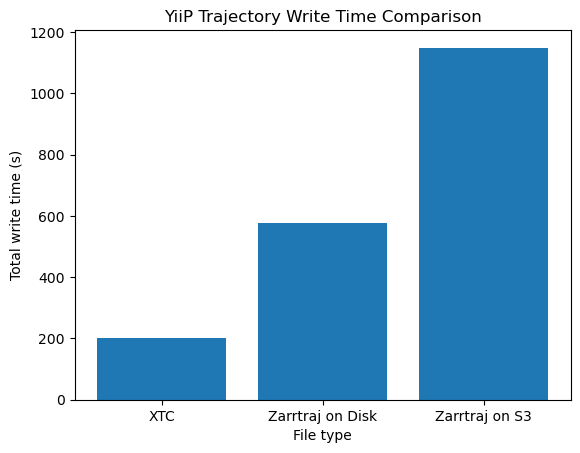

In [16]:
import matplotlib.pyplot as plt

# 5. Graph performance.

with open('notebook_data_tmp/write_speeds.json', 'r') as j:
    data = json.load(j)

time_vals = [data["XTC"], data["Zarrtraj_Disk"], data["Zarrtraj_S3"]]
filenames = ["XTC", "Zarrtraj on Disk", "Zarrtraj on S3"]

plt.bar(filenames, time_vals)
plt.title('YiiP Trajectory Write Time Comparison')
plt.xlabel('File type')
plt.ylabel('Total write time (s)')

plt.savefig("write_speeds.svg", format='svg')
plt.show()